#  Extending from nb15.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from matplotlib import cm

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
if True:
    from imblearn.under_sampling import TomekLinks, RandomUnderSampler
    from imblearn.over_sampling import SMOTE, ADASYN

In [3]:
if True:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.feature_selection import RFECV

In [4]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

# Preprocess Majority

In [5]:
train = pd.read_csv('./train.csv')
bincat = pd.read_csv('./data/class_associated_bincat_features.csv')
ordinal = pd.read_csv('./data/class_associated_ordinal_features.csv')
data = pd.concat([bincat, ordinal, train.target], axis=1)

In [42]:
feature_list = data.iloc[:, :-1].columns
feature_list 

Index(['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin',
       'ps_ind_12_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin',
       'ps_car_01_cat_NaN', 'ps_car_01_cat_0',
       ...
       'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_ind_01', 'ps_ind_03',
       'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03'],
      dtype='object', length=143)

In [36]:
X = np.array(data.iloc[:, :-1])
y = np.array(data.iloc[:, -1])

In [37]:
X.shape, y.shape

((595212, 143), (595212,))

In [8]:
# No Tomek Links for now
if False:
    tl = TomekLinks(n_jobs=8, ratio='majority')
    X_tl, y_tl = tl.fit_sample(X, y)

    print('Before tomek links: size of X: ', X.shape)
    print('After  tomek links: size of X: ', X_tl.shape)
    print('Before tomek links: class0/class1 = %d / %d' % (len(y)-np.sum(y), np.sum(y)))
    print('After  tomek links: class0/class1 = %d / %d' % (len(y_tl)-np.sum(y_tl), np.sum(y_tl)))

### Run classification multiple rounds with random train_test splitting (try 10 times)

XGB Mean Gini: 0.263+/-0.004, Best=0.269
CPU times: user 7min 38s, sys: 2.62 s, total: 7min 41s
Wall time: 1min 18s


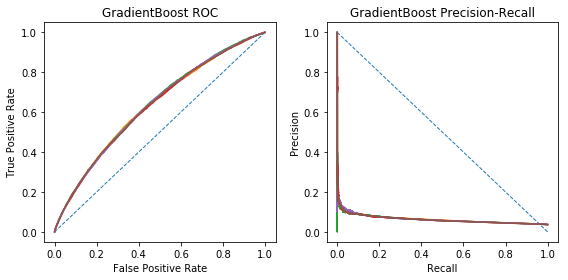

In [38]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):
    
    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rstate)
    
    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = XGBClassifier(gamma=1, max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('XGB Mean Gini: %.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

## Recursive Feature Elimination with XGBoost

In [40]:
rstate = None
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rstate)

num_class1 = np.sum(y)
num_class1_to_resample = 2 * num_class1
num_class0_to_resample = int(1 * num_class1_to_resample)

# First, randomly undersample the majority
rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
X_tlrus, y_tlrus = rus.fit_sample(X, y)

# Then use SMOTE to oversample the minority
smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

In [41]:
%%time
xgb = XGBClassifier(gamma=1, max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
selector = RFECV(xgb, step=1, cv=5, scoring=gini_scorer)
selector = selector.fit(X_res, y_res)

CPU times: user 1h 24min 34s, sys: 6.01 s, total: 1h 24min 40s
Wall time: 11min 3s


In [43]:
rankings = pd.Series(selector.ranking_)
rfe_feature_list = list(feature_list[rankings == 1])

In [44]:
print('# features before RFE: %d' % (len(feature_list)))
print('# features after  RFE: %d' % (len(rfe_feature_list)))

# features before RFE: 143
# features after  RFE: 143


XGB Mean Gini: 0.272+/-0.009, Best=0.286
CPU times: user 8min 35s, sys: 2.41 s, total: 8min 38s
Wall time: 1min 29s


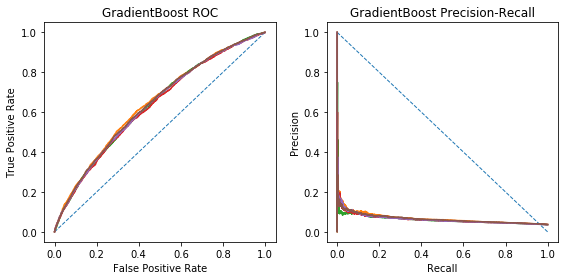

In [25]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

X_new = np.array(data.loc[:, rfe_feature_list])
y = np.array(data.iloc[:, -1])

for i in range(5):
    
    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.1, random_state=rstate)
    
    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = XGBClassifier(gamma=1, max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('XGB Mean Gini: %.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))